<a href="https://colab.research.google.com/github/som-pat/CSNN-Image-Recognition/blob/main/SNN_FashionMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install snntorch --quiet
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen
from snntorch import surrogate

import torch
import torch.nn as nn
from torch.utils.data import DataLoader,random_split
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau


import matplotlib.pyplot as plt
import numpy as np
import itertools
from snntorch import functional as SF
from snntorch import spikegen

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 1.3 MB/s eta 0:00:00


In [ ]:
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
import torch
import torch.nn as nn
from torchvision.utils import make_grid
from torchvision.utils import save_image
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
import random
%matplotlib inline

In [ ]:
batch_size = 128
data_path='/data/Dataloader'

dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

##Dataset

## Fashion_Mnist

In [ ]:
def DogFilter(img):
  img = transforms.functional.gaussian_blur(img,kernel_size=3,sigma=3.0 ) - transforms.functional.gaussian_blur(img,kernel_size=3,sigma=0.5 )
  return img

In [ ]:
transform = transforms.Compose([
            transforms.Resize((28, 28)),
            # transforms.GaussianBlur(kernel_size = (5,7),sigma = (0.1,5)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,)),
            # DogFilter
            ])

train = datasets.FashionMNIST(data_path, train=True, download=True, transform=transform)
test = datasets.FashionMNIST(data_path, train=False, download=True, transform=transform)

In [ ]:
train

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: /data/Dataloader
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=(28, 28), interpolation=bilinear, max_size=None, antialias=warn)
               Grayscale(num_output_channels=1)
               ToTensor()
               Normalize(mean=(0,), std=(1,))
           )

In [ ]:
train,valid = random_split(train,[48000,12000])

In [ ]:
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, drop_last=True)
valid_loader = DataLoader(valid, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=True, drop_last=True)

In [ ]:
num_inputs = 28
num_hidden = 1024
num_outputs=10
in_input = 6272
# Temporal Dynamics
num_steps = 30
beta = 0.9

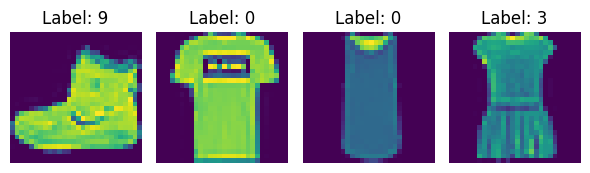

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(6, 6))  # Create a horizontal line of subplots

for i in range(4):
    image, label = train[i]
    axs[i].imshow(image.permute(1, 2, 0))   # Display the grayscale image
    axs[i].set_title(f"Label: {label}")
    axs[i].axis('off')  # Turn off axis labels and ticks

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Gain = 2.0')

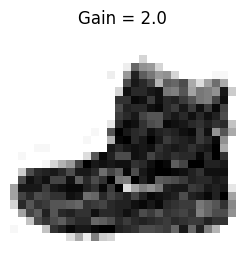

In [ ]:
import matplotlib.pyplot as plt
import snntorch.spikeplot as splt
from IPython.display import HTML
image, label = train[0]
images1 = spikegen.rate(image[0], num_steps,gain = 1.0)
spike_data_sample = images1
plt.figure(facecolor="w")
plt.subplot(1,2,1)
plt.imshow(spike_data_sample.mean(axis=0).reshape((28,-1)).cpu(), cmap='binary')
plt.axis('off')
plt.title('Gain = 2.0')

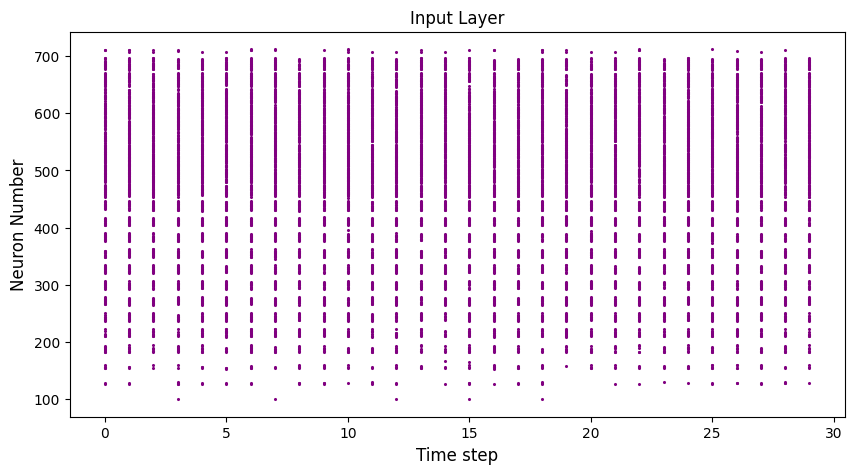

In [ ]:
spike_data = spike_data_sample.reshape(num_steps, -1)

# raster plot
fig = plt.figure(facecolor="w", figsize=(10, 5))
ax = fig.add_subplot(111)
splt.raster(spike_data, ax, s=1.5, c="purple")
  # Turn off the axis
ax.xaxis.label.set_fontsize(12)
ax.yaxis.label.set_fontsize(12)
plt.title("Input Layer")
plt.xlabel("Time step")
plt.ylabel("Neuron Number")
plt.show()

In [ ]:
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

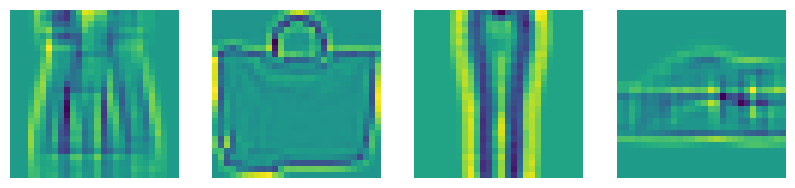

In [ ]:
data_iter = iter(train_loader)

images, labels = next(data_iter)
fig, axes = plt.subplots(figsize=(10,4), ncols=4)
for ii in range(4):
    ax = axes[ii]
#     helper.imshow(images[ii], ax=ax, normalize=False)
    imshow(images[ii], ax=ax, normalize=False)

##Model

In [ ]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        spike_grad = surrogate.atan()

        # Initialize layers
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1,)
        self.bn1 = nn.BatchNorm2d(16)
        self.lif1 = snn.Leaky(beta=beta,learn_threshold=True,spike_grad=spike_grad,learn_beta=True)
        self.mp1 = nn.MaxPool2d(2)

        self.conv2 = nn.Conv2d(16, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64,)
        self.lif2 = snn.Leaky(beta=beta,spike_grad=spike_grad,learn_beta=True)
        self.mp2 = nn.MaxPool2d(2)


        #mnist,FashionMnist:6272,1152
        #cifar10 = 2048
        self.fc1 = nn.Linear(3136,8192)
        self.lif3 = snn.Leaky(beta=beta,learn_beta=True,spike_grad=spike_grad)

        self.fc2 = nn.Linear(8192,4096)
        self.lif4 = snn.Leaky(beta =beta,learn_beta=True,spike_grad=spike_grad)

        self.fc5 = nn.Linear(4096,num_outputs)
        self.lif7 = snn.Leaky(beta=beta,spike_grad=spike_grad,learn_beta = True)

    def forward(self, x):

        # Initialize hidden states at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()
        mem4 = self.lif4.init_leaky()
        # mem5 = self.lif5.init_leaky()
        # mem6 = self.lif6.init_leaky()
        mem7 = self.lif7.init_leaky()
        # omem1 = self.olif1.init_leaky()


        # Record the final layer
        spk3_rec = []
        mem3_rec = []

        # time-loop
        for step in range(x.size(0)):
            # print(x)
            cur1 = self.conv1(x[step])
            cur1 = self.bn1(cur1)
            spk1, mem1 = self.lif1(self.mp1(cur1), mem1)
            cur2 = self.conv2(spk1)
            cur2 = self.bn2(cur2)
            spk2, mem2 = self.lif2(self.mp2(cur2), mem2)
            # ocur1 = self.conv3(spk2)
            # ocur1 = self.bn3(ocur1)
            # ospk1, omem1 = self.olif1(self.mp3(ocur1),omem1)
            cur3 = self.fc1(spk2.flatten(1))
            spk3, mem3 = self.lif3(cur3, mem3)
            cur4 = self.fc2(spk3)
            spk4, mem4 = self.lif4(cur4, mem4)
            # cur5 = self.fc3(spk4)
            # spk5, mem5 = self.lif5(cur5, mem5)
            # cur6 = self.fc4(spk5)
            # spk6, mem6 = self.lif6(cur6, mem6)
            cur7 = self.fc5(spk4)
            spk7, mem7 = self.lif7(cur7, mem7)

            spk3_rec.append(spk7)
            mem3_rec.append(mem7)

        return torch.stack(spk3_rec, dim=0), torch.stack(mem3_rec, dim=0)

# Load the network onto CUDA if available
convnet = ConvNet().to(device)

In [ ]:
train_acc= []
test_acc =[]
def calc_accuracy(spk_rec,targets,Train):
    _, idx = spk_rec.sum(dim=0).max(1)
    acc = np.mean((targets == idx).detach().cpu().numpy())
    # acc = SF.accuracy_rate(spk_rec,targets)

    if Train==True:
        train_acc.append(acc*100)
        return acc*100
    elif Train ==False :
        test_acc.append(acc*100)
        return acc*100

In [ ]:
# torch components
def loss(spk_rec,targets):
  l = nn.CrossEntropyLoss()
  l(spk_rec.sum(0), targets)
  return l


In [ ]:
#Spike loss component
def loss(spk_rec,targets):
  l = SF.ce_count_loss()
  l(spk_rec, targets)
  return l

In [ ]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [ ]:
loss = nn.CrossEntropyLoss() #SF.ce_count_loss()
optimizer = torch.optim.Adam(convnet.parameters(), lr=7e-5, betas=(0.9, 0.999))
early_stopper = EarlyStopper(patience=5, min_delta=10)

num_epochs = 8
loss_hist = []
valid_loss_hist = []
counter = 0
prune_percentage = 0.1


# Outer training loop
for epoch in range(num_epochs):
    train_batch = iter(train_loader)

    # Minibatch training loop
    for data, targets in train_batch:
        data = data.to(device)
        targets = targets.to(device)
        # print(data.size())
        # forward pass
        convnet.train()

        data = spikegen.rate(data, num_steps=num_steps)
        # print(data.size())
        spk_rec, mem_rec = convnet(data)

        # initialize the loss & sum over time
        loss_val = torch.zeros((1), dtype=dtype, device=device)
        loss_val = loss(spk_rec.sum(0), targets)
        # loss_val = loss(spk_rec, targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        for module in convnet.modules():

              if isinstance(module, nn.Conv2d):
                weights = module.weight.data
                threshold = torch.kthvalue(torch.abs(weights).view(-1), int(prune_percentage * weights.numel()))[0]
                pruned_weights = torch.where(torch.abs(weights) < threshold, torch.tensor(0), weights)
                module.weight.data = pruned_weights


        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        with torch.no_grad():
            convnet.eval()
            valid_data, valid_targets = next(iter(valid_loader))
            valid_data = valid_data.to(device)
            valid_targets = valid_targets.to(device)

            # Test set forward pass
            valid_data = spikegen.rate(valid_data, num_steps=num_steps)
            # print(valid_data.size())
            valid_spk, valid_mem = convnet(valid_data)

            # # Test set loss
            valid_loss = torch.zeros((1), dtype=dtype, device=device)
            valid_loss = loss(valid_spk.sum(0), valid_targets)
            # valid_loss_val =loss(valid_spk, valid_targets)
            valid_loss_hist.append(valid_loss.item())
            if early_stopper.early_stop(valid_loss):
              break

        # Print train/test loss/accuracy
        if counter % 10 == 0:
            print(f"Iteration: {counter}, Train Loss: {loss_val.item()} \t Validation Loss: {valid_loss.item()}")
            print(f"\t\t Training Accuracy:{calc_accuracy(spk_rec,targets,Train=True)} \t Validation Accuracy: {calc_accuracy(valid_spk,valid_targets,Train=False)}  ")
        counter += 1

Iteration: 0, Train Loss: 2.33479380607605 	 Validation Loss: 2.2141330242156982
		 Training Accuracy:7.03125 	 Validation Accuracy: 13.28125  
Iteration: 10, Train Loss: 2.1812949180603027 	 Validation Loss: 2.0334713459014893
		 Training Accuracy:33.59375 	 Validation Accuracy: 26.5625  
Iteration: 20, Train Loss: 1.7541725635528564 	 Validation Loss: 1.7002921104431152
		 Training Accuracy:42.96875 	 Validation Accuracy: 46.875  
Iteration: 30, Train Loss: 1.7585150003433228 	 Validation Loss: 1.729515790939331
		 Training Accuracy:44.53125 	 Validation Accuracy: 39.84375  
Iteration: 40, Train Loss: 1.6158124208450317 	 Validation Loss: 1.5731076002120972
		 Training Accuracy:47.65625 	 Validation Accuracy: 47.65625  
Iteration: 50, Train Loss: 1.5157262086868286 	 Validation Loss: 1.537153959274292
		 Training Accuracy:48.4375 	 Validation Accuracy: 48.4375  
Iteration: 60, Train Loss: 1.3973312377929688 	 Validation Loss: 1.5302828550338745
		 Training Accuracy:57.8125 	 Validati

In [ ]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=2, shuffle=True)

In [ ]:
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(convnet.parameters(), lr=7e-5, betas=(0.9, 0.999))
early_stopper = EarlyStopper(patience=5, min_delta=10)

num_epochs = 4
loss_hist = []
valid_loss_hist = []
counter = 0
prune_percentage = 0.1

for fold, (t_indices,v_indices) in enumerate(kf.split(train)):
    train_sam = torch.utils.data.SubsetRandomSampler(t_indices)
    val_sam= torch.utils.data.SubsetRandomSampler(v_indices)

    train_loader = torch.utils.data.DataLoader(dataset=train, batch_size=batch_size, sampler=train_sam)
    valid_loader = torch.utils.data.DataLoader(dataset=train, batch_size=batch_size, sampler=val_sam)

# Outer training loop
    for epoch in range(num_epochs):
        train_batch = iter(train_loader)

        # Minibatch training loop
        for data, targets in train_batch:
            data = data.to(device)
            targets = targets.to(device)

            # forward pass
            convnet.train()
            data = spikegen.rate(data, num_steps=num_steps,gain=2.0)
            spk_rec, mem_rec = convnet(data)

            # initialize the loss & sum over time
            loss_val = torch.zeros((1), dtype=dtype, device=device)
            loss_val = loss(spk_rec.sum(0), targets)
            # loss_val = loss(spk_rec, targets)

            # Gradient calculation + weight update
            optimizer.zero_grad()
            loss_val.backward()

            for module in convnet.modules():

              if isinstance(module, nn.Conv2d):
                weights = module.weight.data
                threshold = torch.kthvalue(torch.abs(weights).view(-1), int(prune_percentage * weights.numel()))[0]
                pruned_weights = torch.where(torch.abs(weights) < threshold, torch.tensor(0), weights)
                module.weight.data = pruned_weights

            optimizer.step()

            # Store loss history for future plotting
            loss_hist.append(loss_val.item())

            with torch.no_grad():
                convnet.eval()
                valid_data, valid_targets = next(iter(valid_loader))
                valid_data = valid_data.to(device)
                valid_targets = valid_targets.to(device)

                # Test set forward pass
                valid_data = spikegen.rate(valid_data, num_steps=num_steps,gain=2.0)
                valid_spk, valid_mem = convnet(valid_data)

                # # Test set loss
                valid_loss_val = torch.zeros((1), dtype=dtype, device=device)
                valid_loss_val = loss(valid_spk.sum(0), valid_targets)
                # valid_loss_val =loss(valid_spk, valid_targets)
                valid_loss_hist.append(valid_loss_val.item())
                if early_stopper.early_stop(valid_loss_val):
                  break


            # Print train/test loss/accuracy
            if counter % 10 == 0:
                print(f"Iteration: {counter}, Train Loss: {loss_val.item()} \t Validation Loss: {valid_loss_val.item()}")
                print(f"\t\t Training Accuracy:{calc_accuracy(spk_rec,targets,Train=True)} \t Validation Accuracy: {calc_accuracy(valid_spk,valid_targets,Train=False)}  ")
            counter += 1

Iteration: 0, Train Loss: 2.304682731628418 	 Validation Loss: 3.189436912536621
		 Training Accuracy:11.71875 	 Validation Accuracy: 31.25  
Iteration: 10, Train Loss: 2.028660774230957 	 Validation Loss: 1.9400699138641357
		 Training Accuracy:21.09375 	 Validation Accuracy: 30.46875  
Iteration: 20, Train Loss: 1.8182824850082397 	 Validation Loss: 1.7054115533828735
		 Training Accuracy:32.8125 	 Validation Accuracy: 34.375  
Iteration: 30, Train Loss: 1.7659101486206055 	 Validation Loss: 1.6685657501220703
		 Training Accuracy:28.90625 	 Validation Accuracy: 36.71875  
Iteration: 40, Train Loss: 1.798461675643921 	 Validation Loss: 1.5731871128082275
		 Training Accuracy:32.8125 	 Validation Accuracy: 38.28125  
Iteration: 50, Train Loss: 1.4536323547363281 	 Validation Loss: 1.4167745113372803
		 Training Accuracy:47.65625 	 Validation Accuracy: 42.96875  
Iteration: 60, Train Loss: 1.6259969472885132 	 Validation Loss: 1.704149603843689
		 Training Accuracy:42.96875 	 Validatio

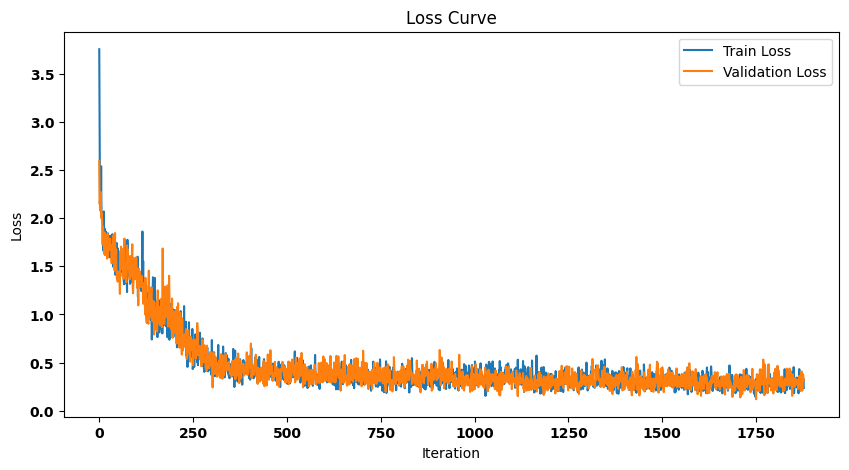

In [ ]:
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(loss_hist[2:])
plt.plot(valid_loss_hist[2:])
plt.title("Loss Curve")
plt.legend(["Train Loss", "Validation Loss"])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')
plt.show()

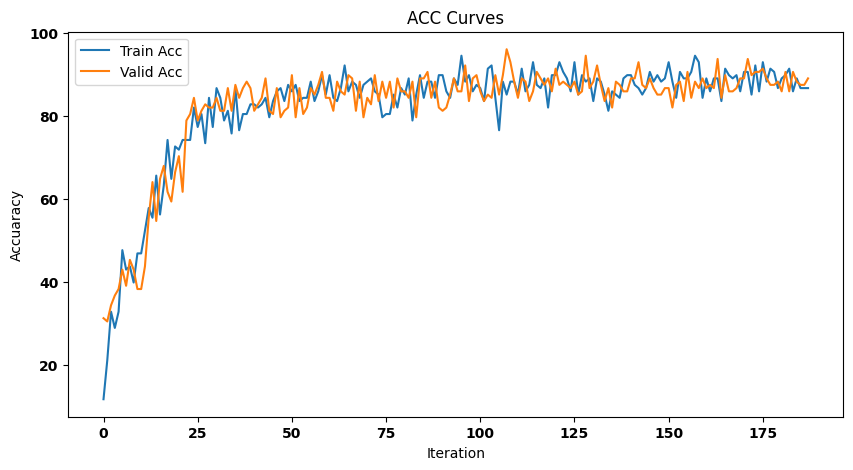

In [ ]:
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(train_acc)
plt.plot(test_acc)
plt.title("ACC Curves")
plt.legend(["Train Acc", "Valid Acc"])
plt.xlabel("Iteration")
plt.ylabel("Accuaracy")
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')
plt.show()

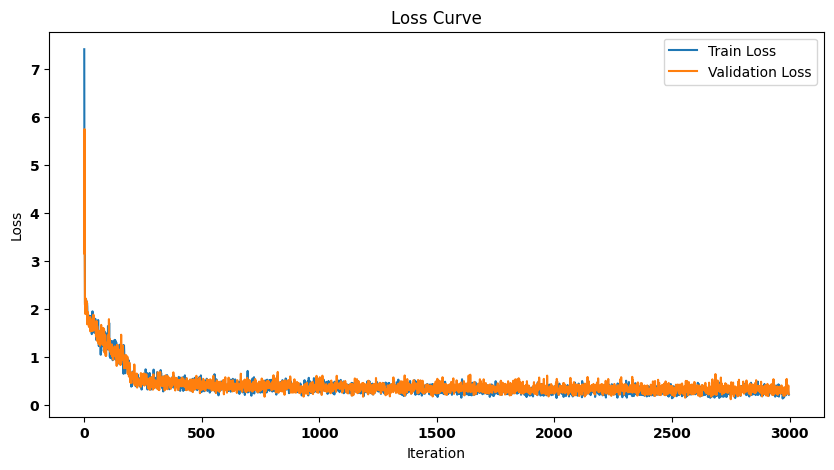

In [ ]:
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(loss_hist[2:])
plt.plot(valid_loss_hist[2:])
plt.title("Loss Curve")
plt.legend(["Train Loss", "Validation Loss"])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')
plt.show()

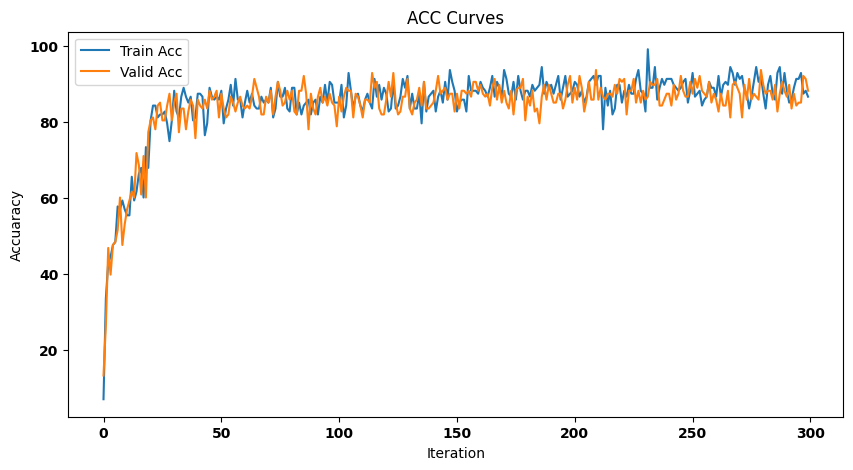

In [ ]:
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(train_acc)
plt.plot(test_acc)
plt.title("ACC Curves")
plt.legend(["Train Acc", "Valid Acc"])
plt.xlabel("Iteration")
plt.ylabel("Accuaracy")
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')
plt.show()

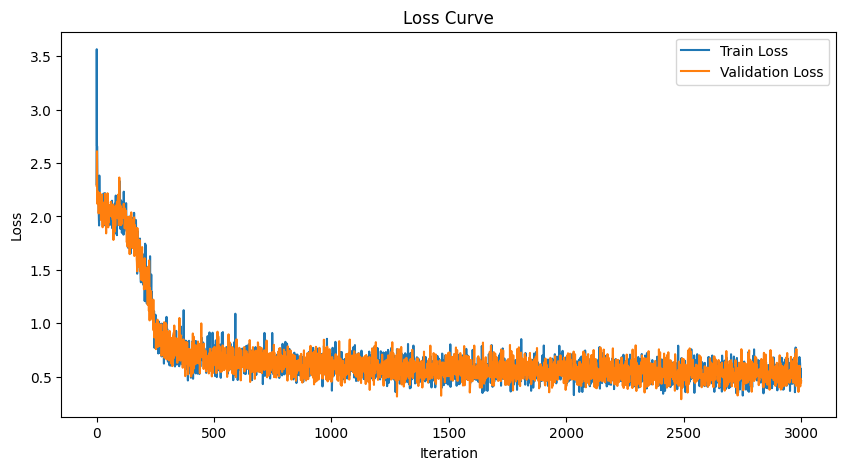

In [ ]:
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(loss_hist)
plt.plot(valid_loss_hist)
plt.title("Loss Curve")
plt.legend(["Train Loss", "Validation Loss"])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

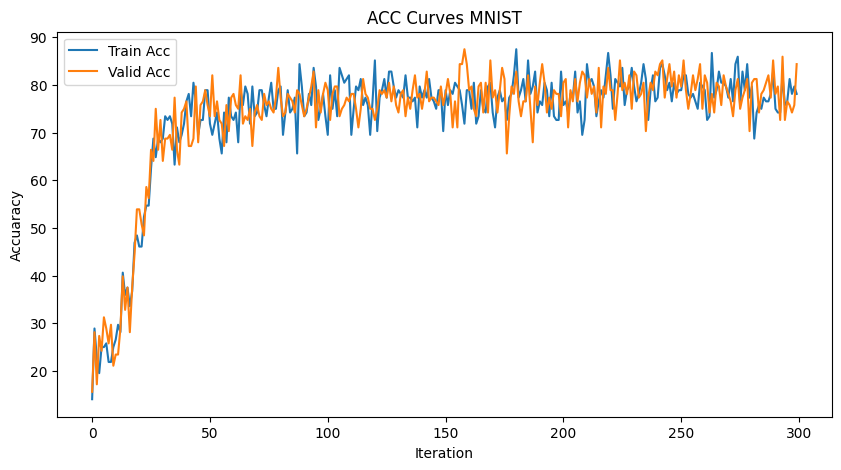

In [ ]:
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(train_acc)
plt.plot(test_acc)
plt.title("ACC Curves MNIST")
plt.legend(["Train Acc", "Valid Acc"])
plt.xlabel("Iteration")
plt.ylabel("Accuaracy")
plt.show()

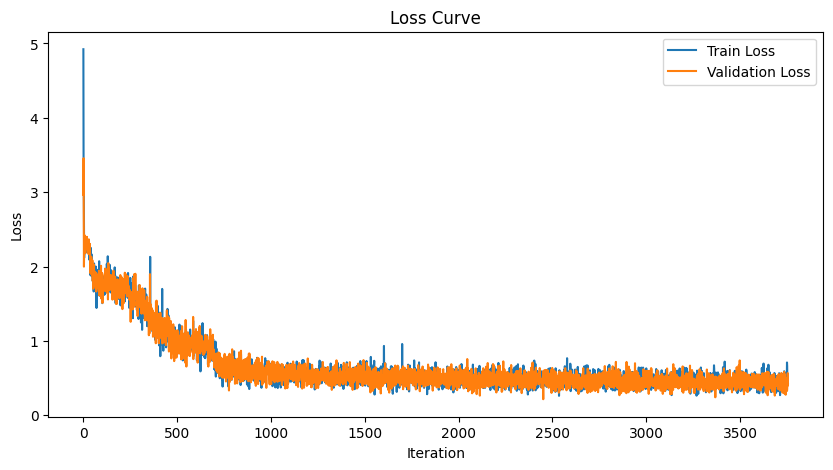

In [ ]:
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(loss_hist)
plt.plot(valid_loss_hist)
plt.title("Loss Curve")
plt.legend(["Train Loss", "Validation Loss"])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

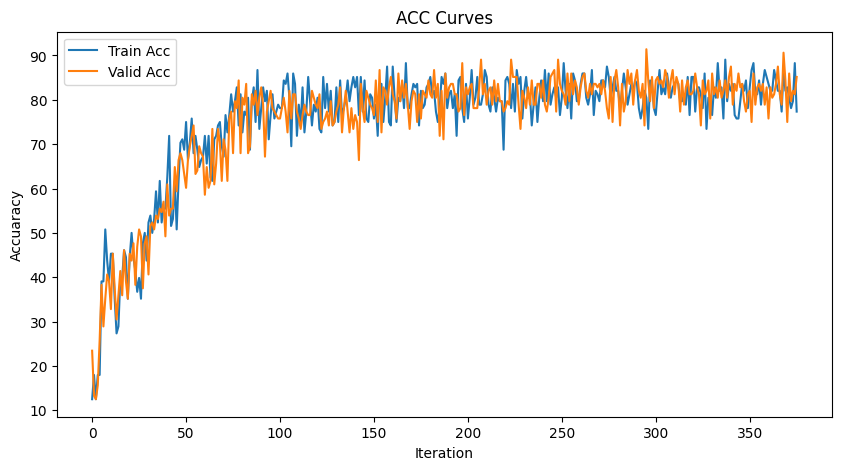

In [ ]:
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(train_acc)
plt.plot(test_acc)
plt.title("ACC Curves")
plt.legend(["Train Acc", "Valid Acc"])
plt.xlabel("Iteration")
plt.ylabel("Accuaracy")
plt.show()

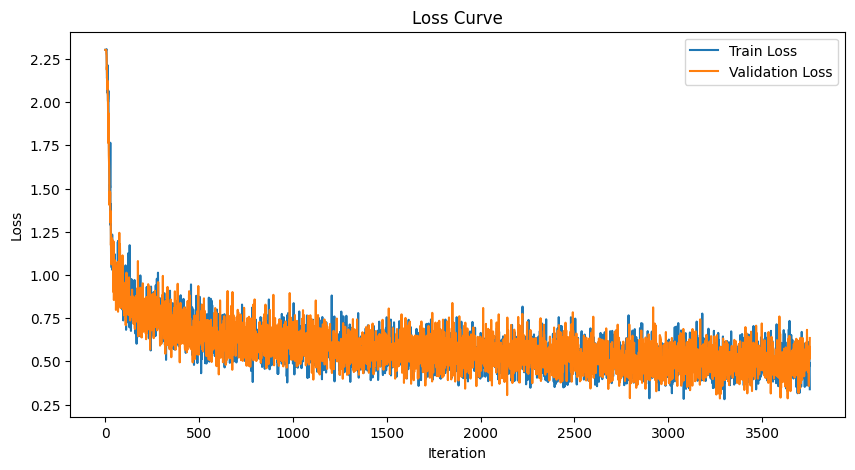

In [ ]:
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(loss_hist)
plt.plot(valid_loss_hist)
plt.title("Loss Curve")
plt.legend(["Train Loss", "Validation Loss"])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

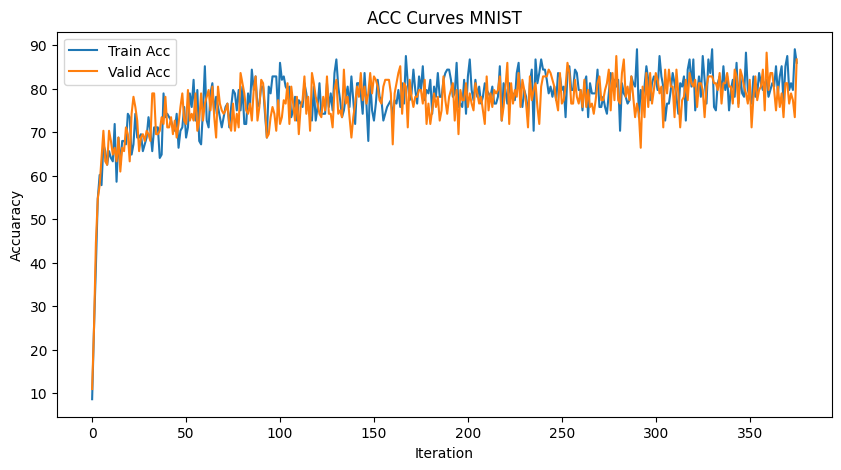

In [ ]:
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(train_acc)
plt.plot(test_acc)
plt.title("ACC Curves MNIST")
plt.legend(["Train Acc", "Valid Acc"])
plt.xlabel("Iteration")
plt.ylabel("Accuaracy")
plt.show()

In [ ]:
test_loader = DataLoader(test, batch_size=batch_size, shuffle=True, drop_last=True)
def measure_accuracy(model, dataloader):
  with torch.no_grad():
    model.eval()
    running_length = 0
    running_accuracy = 0

    for data, targets in iter(dataloader):
      data = data.to(device)
      targets = targets.to(device)

      # forward-pass
      data = spikegen.rate(data, num_steps=num_steps)
      spk_rec, _ = model(data)
      spike_count = spk_rec.sum(0)
      _, max_spike = spike_count.max(1)

      # correct classes for one batch
      num_correct = (max_spike == targets).sum()

      # total accuracy
      running_length += len(targets)
      running_accuracy += num_correct

    accuracy = np.mean((targets == max_spike).detach().cpu().numpy())

    return accuracy.item()

print(f"ConvNet Test Accuracy: {measure_accuracy(convnet, test_loader)}")

ConvNet Test Accuracy: 0.8203125


In [ ]:
test_loader = DataLoader(test, batch_size=batch_size, shuffle=True, drop_last=True)
def measure_accuracy(model, dataloader):
  with torch.no_grad():
    model.eval()
    running_length = 0
    running_accuracy = 0

    for data, targets in iter(dataloader):
      data = data.to(device)
      targets = targets.to(device)

      # forward-pass
      data = spikegen.rate(data, num_steps=num_steps)
      spk_rec, _ = model(data)
      spike_count = spk_rec.sum(0)
      _, max_spike = spike_count.max(1)

      # correct classes for one batch
      num_correct = (max_spike == targets).sum()

      # total accuracy
      running_length += len(targets)
      running_accuracy += num_correct

    accuracy = np.mean((targets == max_spike).detach().cpu().numpy())

    return accuracy.item()

print(f"ConvNet Test Accuracy: {measure_accuracy(convnet, test_loader)}")

ConvNet Test Accuracy: 0.890625


The target label is: 7


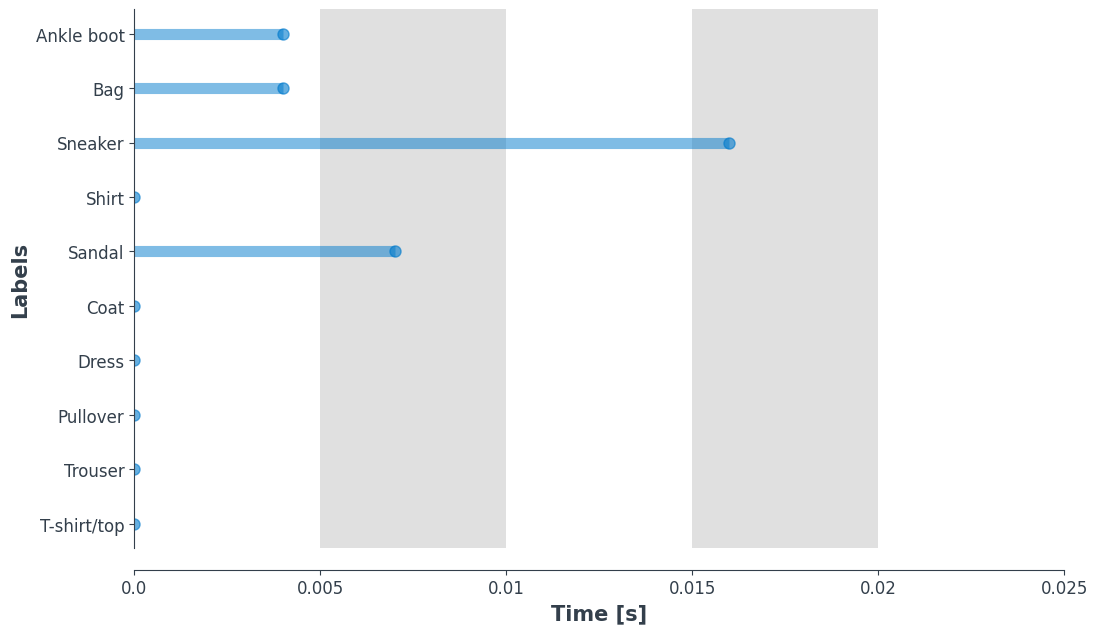

<Figure size 640x480 with 0 Axes>

In [ ]:
#MNIST
import snntorch.spikeplot as splt
import matplotlib.pyplot as plt
from IPython.display import HTML
# print(spk_rec.size())

idx =2

fig, ax = plt.subplots(facecolor='w', figsize=(12, 7))

labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat','Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
print(f"The target label is: {targets[idx]}")

#  Plot and save spike count histogram
splt.spike_count(spk_rec[:, idx].detach().cpu(), fig, ax, labels, num_steps = num_steps,time_step=1e-3)
plt.show()
plt.savefig('hist2.png', dpi=300, bbox_inches='tight')
